In [8]:
import gtsam
from gtsam.utils import plot
import matplotlib.pyplot as plt
import numpy as np

In [59]:
def arr2pose(pose):
    x,y,z = pose[:3]
    qx,qy,qz,qw = pose[3:]
    rot = gtsam.Rot3(qw,qx,qy,qz)
    t = gtsam.Point3(x,y,z)
    return gtsam.Pose3(rot, t)

def arr2info(info):
    m = np.eye(6)

    k = 0
    for i in range(6):
        for j in range(i, 6):
            mij = info[k]
            m[i,j] = mij
            m[j,i] = mij
            k += 1

    mgtsam = np.eye(6)
    mgtsam[:3, :3] = m[3:6, 3:6]
    mgtsam[3:6,3:6] = m[:3, :3]
    mgtsam[0:3, 3:6] = m[0:3, 3:6]
    mgtsam[3:6, 0:3] = m[3:6, 0:3] 
    
    return gtsam.noiseModel.Gaussian.Information(mgtsam)

def read(filename, title1, title2):

    vertex = []  # if line starts with 'VERTEX_SE3:QUAT' we append here
    edge = []  # if line starts with 'EDGE_SE3:QUAT' we append here
    with open(filename) as file:
        for line in file:
            line = line.split()
            
            # if line starts with 'VERTEX_SE3:QUAT'....
            # [VERTEX_SE3:QUAT i x y z qx qy qz qw] ~ [line[0] line[1]  line[2:]]
            if line[0] == title1:
                v = int(line[1])
                pose = np.array(line[2:], dtype = np.float32)  # from x to qw in a single array called pose
                
                # combining v and pose into vertex
                vertex.append([v, pose])

            # if line starts with 'EDGE_SE3:QUAT' ....
            # [EDGE_SE3:QUAT i j x y z qx qy qz qw info(x, y, z, qx, qy, qz)] ~ [line[0] line[1]  line[2:]  line[3:10] line[10:]] 
            elif line[0] == title2:

                pose = np.array(line[3:10], dtype= np.float32) # from x to qw
                info = np.array(line[10:], dtype=np.float32)  # info(x, y, z, qx, qy, qz)

                # combining line[1] = i; line[2] = j ; pose and info into edge
                edge.append([int(line[1]), int(line[2]), pose, info])


    return vertex, edge

In [60]:
(vertex, edge) = read('sphere.g2o', title1 = 'VERTEX_SE3:QUAT', title2 = 'EDGE_SE3:QUAT' )

print(vertex[0])
print(edge[0])
print(arr2info(edge[0][3]))

[0, array([-1.25664e-01, -1.53894e-17,  9.99999e+01,  7.06662e-01,
        4.32706e-17,  7.07551e-01, -4.33250e-17], dtype=float32)]
[0, 1, array([-1.87953e-02,  3.28449e-02, -1.25146e-01,  6.34648e-02,
       -2.50128e-04,  2.37634e-03,  9.97981e-01], dtype=float32), array([10000.,     0.,     0.,     0.,     0.,     0., 10000.,     0.,
           0.,     0.,     0., 10000.,     0.,     0.,     0., 40000.,
           0.,     0., 40000.,     0., 40000.], dtype=float32)]
diagonal sigmas [0.005; 0.005; 0.005; 0.01; 0.01; 0.01];



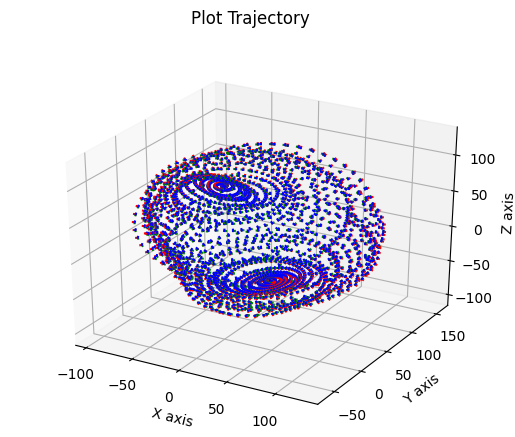

In [61]:
# Create the initial estimates
initial_estimate = gtsam.Values()
for v in vertex:
    pose = arr2pose(v[1])
    initial_estimate.insert(v[0], pose)

# Plot initial estimate
plot.plot_trajectory(1, initial_estimate, scale=1.5)
plot.set_axes_equal(True)
plt.show()

In [62]:
graph = gtsam.NonlinearFactorGraph()
prior_model = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-6, 1e-6, 1e-6, 1e-4, 1e-4, 1e-4]))
graph.add(gtsam.PriorFactorPose3(0, gtsam.Pose3(), prior_model))

# Create odometry (Between) factors between consecutive poses
Between = gtsam.BetweenFactorPose3

odoms = []

for e in edge:
    transf = arr2pose(e[2])
    graph.add(Between(e[0], e[1], transf, arr2info(e[3])))
    odoms.append(transf)

In [63]:
print(graph)

NonlinearFactorGraph: size: 9800

Factor 0: PriorFactor on 0
  prior mean:  R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
t: 0 0 0
  noise model: diagonal sigmas [1e-06; 1e-06; 1e-06; 0.0001; 0.0001; 0.0001];

Factor 1: BetweenFactor(0,1)
  measured:  R: [
	0.999988581, -0.00477483324, -0.000197618121;
	0.00471133594, 0.991933145, -0.126674515;
	0.000800873899, 0.126672138, 0.991944314
]
t: -0.0187953003  0.0328449011  -0.125146002
  noise model: diagonal sigmas [0.005; 0.005; 0.005; 0.01; 0.01; 0.01];

Factor 2: BetweenFactor(1,2)
  measured:  R: [
	0.999994157, -0.00330662708, -0.000867420481;
	0.00316973878, 0.991902322, -0.126963477;
	0.00128021756, 0.126959986, 0.991907007
]
t: -0.00836587045   0.0518558994   -0.141405001
  noise model: diagonal sigmas [0.005; 0.005; 0.005; 0.01; 0.01; 0.01];

Factor 3: BetweenFactor(2,3)
  measured:  R: [
	0.999916505, 0.00502906175, 0.011903454;
	-0.00349631895, 0.992093926, -0.125448877;
	-0.0124402345, 0.125396785, 0.992028674
]
t:    0.0116518 0.064636

In [64]:
# Optimize the initial values using a Gauss-Newton nonlinear optimizer
params = gtsam.GaussNewtonParams()

optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate, params)
result = optimizer.optimize()

print("Optimization complete")
print("initial error = ", graph.error(initial_estimate))
print("final error = ", graph.error(result))

# Extracting poses for plotting
resultPoses = gtsam.utilities.extractPose3(result)
InitialPoses = gtsam.utilities.extractPose3(initial_estimate)

Optimization complete
initial error =  5806890730371.099
final error =  63789.301558689025


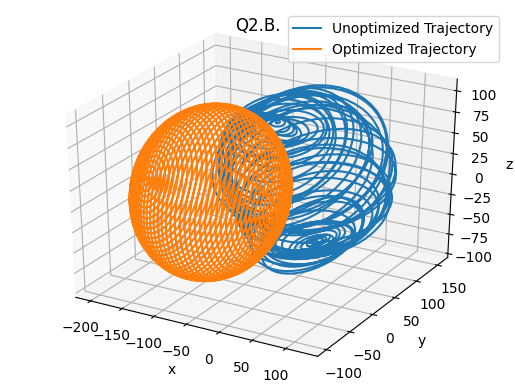

In [65]:
# Plotting the initial and results as Unoptimized and Optimized Trajectory respectively
ax = plt.axes(projection='3d')
ax.plot3D(InitialPoses[:,9], InitialPoses[:,10], InitialPoses[:,11], label="Unoptimized Trajectory")
ax.plot3D(resultPoses[:,9], resultPoses[:,10], resultPoses[:,11], label="Optimized Trajectory")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend(loc='upper right')
plt.title('Q2.B.')
plt.show()